## 3. Preprocessing and modeling

We aim to predict Netflix churn using behavioral signals (watch, search, reviews, recommendations). The goal is not only to score users but to understand which behaviors precede churn so retention can be targeted effectively.

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_fscore_support, RocCurveDisplay, PrecisionRecallDisplay,
    precision_recall_curve, confusion_matrix
)
from sklearn.base import clone
import xgboost as xgb

### Load data

Datasets used: users, watch_history, search_logs, reviews, recommendation_logs, movies. 

We combine user profiles with event logs: 
- watch captures engagement depth
- search logs capture discovery behavior
- reviews capture satisfaction
- recommendation logs capture responsiveness to suggestions. 

In [87]:
df_users  = pd.read_csv("users.csv")
df_watch  = pd.read_csv("watch_history.csv")
df_search = pd.read_csv("search_logs.csv")
df_reviews= pd.read_csv("reviews.csv")
df_recs   = pd.read_csv("recommendation_logs.csv")
df_movies = pd.read_csv("movies.csv")

assert "user_id" in df_users.columns, "users.csv must contain 'user_id'"
assert "is_active" in df_users.columns, "users.csv must contain 'is_active' (True/False)"

### Feature engineering

In addition to totals and averages, we include recency and simple ratios (e.g., clicks per search). These are early proxies for behavioral drop-off.

Customers who recently stopped watching are more likely to churn. We compute days_since_last_event and “days since watch/search/review/rec” as time-sensitive signals. These features are proxies for user engagement decline: fewer searches or a long gap since last activity often signal higher churn risk.

In [60]:
# Convert event_time columns to UTC
def to_dt_utc(df, col="event_time"):
    if df is not None and col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce", utc=True)

for _df in [df_watch, df_search, df_reviews, df_recs]:
    to_dt_utc(_df, "event_time")

# Make sure users have an as_of_date
if "as_of_date" in df_users.columns:
    df_users["as_of_date"] = pd.to_datetime(df_users["as_of_date"], errors="coerce", utc=True)
else:
    def _max_dt(df):
        return df["event_time"].max() if (df is not None and "event_time" in df.columns) else pd.NaT
    candidates = [d for d in [_max_dt(df_watch), _max_dt(df_search), _max_dt(df_reviews), _max_dt(df_recs)] if pd.notnull(d)]
    if candidates:
        global_as_of = pd.Series(candidates).max()
        df_users["as_of_date"] = global_as_of if global_as_of.tzinfo else global_as_of.tz_localize("UTC")
    else:
        now = pd.Timestamp.utcnow()
        df_users["as_of_date"] = now if now.tzinfo else now.tz_localize("UTC")

# For each user, find their last_* activity up to as_of_date
def last_event_upto_asof(log_df, name):
    if log_df is None or "event_time" not in log_df.columns:
        return pd.DataFrame(columns=["user_id", f"last_{name}"])
    d = log_df.merge(df_users[["user_id","as_of_date"]], on="user_id", how="inner")
    d = d.loc[d["event_time"] <= d["as_of_date"]]
    if d.empty:
        return pd.DataFrame(columns=["user_id", f"last_{name}"])
    g = d.groupby("user_id", as_index=False)["event_time"].max()
    g = g.rename(columns={"event_time": f"last_{name}"})
    return g

last_watch  = last_event_upto_asof(df_watch,  "watch")
last_search = last_event_upto_asof(df_search, "search")
last_review = last_event_upto_asof(df_reviews,"review")
last_rec    = last_event_upto_asof(df_recs,   "rec")

df_users = (df_users
    .drop(columns=["last_watch","last_search","last_review","last_rec",
                   "last_event_time","days_since_last_event"], errors="ignore")
    .merge(last_watch,  on="user_id", how="left")
    .merge(last_search, on="user_id", how="left")
    .merge(last_review, on="user_id", how="left")
    .merge(last_rec,    on="user_id", how="left")
)

# Standardize times to UTC and compute days_since_last_event
for c in ["last_watch","last_search","last_review","last_rec"]:
    df_users[c] = pd.to_datetime(df_users[c], errors="coerce", utc=True)

df_users["last_event_time"] = df_users[["last_watch","last_search","last_review","last_rec"]].max(axis=1, skipna=True)
delta = df_users["as_of_date"] - df_users["last_event_time"]
df_users["days_since_last_event"] = delta.dt.days.where(df_users["last_event_time"].notna(), np.inf)

# Add per-feature "days since" fields
for src, dst in [("last_watch","days_since_watch"),
                 ("last_search","days_since_search"),
                 ("last_review","days_since_review"),
                 ("last_rec","days_since_rec")]:
    d = (df_users["as_of_date"] - df_users[src]).dt.days
    df_users[dst] = d.where(df_users[src].notna(), np.inf)

### Target definition: churn
We define churn from is_active: inactive users are labeled churn = 1. 

In [62]:
df_users["is_active"] = df_users["is_active"].astype(bool)
df_users["churn"] = (~df_users["is_active"]).astype(int)
print("Target defined. Churn rate:", df_users["churn"].mean().round(3))

Target defined. Churn rate: 0.148


### Handling invalid and missing values

In [89]:
# Replace inf values with NaN to avoid warnings and keep types consistent
df_users = df_users.replace([np.inf, -np.inf], np.nan).infer_objects(copy=False)

# Drop any columns that are entirely NaN (useless)
all_nan_cols = df_users.columns[df_users.isna().all()].tolist()
if all_nan_cols:
    print("Dropping all-NaN columns:", all_nan_cols)
    df_users = df_users.drop(columns=all_nan_cols)

### Train/Test + Preprocessing

We impute and scale numeric features. Categoricals are imputed and one-hot encoded. We use a stratified split to preserve the churn rate in train/test.

In [66]:
TARGET = "churn"

drop_cols = [
    "user_id", "is_active",
    "as_of_date","last_event_time",
    "last_watch","last_search","last_review","last_rec"  # raw timestamps
]

keep_cols = [c for c in df_users.columns if c not in drop_cols + [TARGET]]
X = df_users[keep_cols].copy()
y = df_users[TARGET].astype(int)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number, "bool"]).columns.tolist()

numeric_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler())
])

categorical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
]) if len(cat_cols) else None

preproc = ColumnTransformer(
    [("num", numeric_pipe, num_cols)] + ([("cat", categorical_pipe, cat_cols)] if categorical_pipe else []),
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print("Preprocessing setup complete.")
print(f"Shapes -> X_train: {X_train.shape} | X_test: {X_test.shape}")
print(f"Pos class ratio (train/test): {y_train.mean():.3f} / {y_test.mean():.3f}")
print(f"Numeric cols: {len(num_cols)} | Categorical cols: {len(cat_cols)}")

Preprocessing setup complete.
Shapes -> X_train: (8240, 14) | X_test: (2060, 14)
Pos class ratio (train/test): 0.148 / 0.148
Numeric cols: 3 | Categorical cols: 11


### Modeling & evaluation 

We compare Dummy (baseline), Logistic Regression, Random Forest (1000 trees) and XGBoost (2000 estimators + early stopping). PR AUC is the primary metric due to class imbalance (15% churn).

In [68]:
# Final cleanup for train/test 
def sanitize_inf(df): 
    return df.replace([np.inf, -np.inf], np.nan)

X_train_s = sanitize_inf(X_train)
X_test_s  = sanitize_inf(X_test)

rows = []

# 1) Dummy (Baseline)
dummy = DummyClassifier(strategy="most_frequent", random_state=42).fit(X_train_s, y_train)
y_pred_dummy  = dummy.predict(X_test_s)
y_proba_dummy = dummy.predict_proba(X_test_s)[:, 1]
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_dummy, average="binary", zero_division=0)
rows.append({"Model":"Dummy(majority)","ROC AUC":roc_auc_score(y_test, y_proba_dummy),
             "PR AUC":average_precision_score(y_test, y_proba_dummy),
             "Precision":prec,"Recall":rec,"F1":f1})

# 2) Logistic Regression
logreg = Pipeline([("preproc", preproc), ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))])
logreg.fit(X_train_s, y_train)
y_pred_lr  = logreg.predict(X_test_s)
y_proba_lr = logreg.predict_proba(X_test_s)[:, 1]
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_lr, average="binary", zero_division=0)
rows.append({"Model":"LogisticRegression","ROC AUC":roc_auc_score(y_test, y_proba_lr),
             "PR AUC":average_precision_score(y_test, y_proba_lr),
             "Precision":prec,"Recall":rec,"F1":f1})

# Random Forest
rf = Pipeline([("preproc", preproc),
               ("clf", RandomForestClassifier(n_estimators=1000, class_weight="balanced",
                                              random_state=42, n_jobs=-1))])
rf.fit(X_train_s, y_train)
y_pred_rf  = rf.predict(X_test_s)
y_proba_rf = rf.predict_proba(X_test_s)[:, 1]
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_rf, average="binary", zero_division=0)
rows.append({"Model":"RandomForest(1000)","ROC AUC":roc_auc_score(y_test, y_proba_rf),
             "PR AUC":average_precision_score(y_test, y_proba_rf),
             "Precision":prec,"Recall":rec,"F1":f1})

# XGBoost 
preproc_xgb = clone(preproc)
X_train_t = preproc_xgb.fit_transform(X_train_s)
X_test_t  = preproc_xgb.transform(X_test_s)

pos = int(y_train.sum())
neg = int(len(y_train) - pos)
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

dtrain = xgb.DMatrix(X_train_t, label=y_train)
dvalid = xgb.DMatrix(X_test_t,  label=y_test)

params = dict(
    objective="binary:logistic",
    eval_metric="logloss",
    eta=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

bst = xgb.train(params, dtrain, num_boost_round=2000, evals=[(dvalid,"valid")],
                early_stopping_rounds=50, verbose_eval=False)

y_proba_xgb = bst.predict(dvalid, iteration_range=(0, bst.best_iteration + 1))
y_pred_xgb  = (y_proba_xgb >= 0.5).astype(int)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_xgb, average="binary", zero_division=0)
rows.append({"Model":"XGBoost(2000, ES=50)","ROC AUC":roc_auc_score(y_test, y_proba_xgb),
             "PR AUC":average_precision_score(y_test, y_proba_xgb),
             "Precision":prec,"Recall":rec,"F1":f1})

results_df = pd.DataFrame(rows).round(4).sort_values("PR AUC", ascending=False).reset_index(drop=True)
results_df

,Model,ROC AUC,PR AUC,Precision,Recall,F1
0,RandomForest(1000),0.5677,0.2407,1.0000,0.0623,0.1173
1,LogisticRegression,0.5480,0.2179,0.2384,0.1344,0.1719
2,"XGBoost(2000, ES=50)",0.5423,0.1852,0.1983,0.3016,0.2393
3,Dummy(majority),0.5000,0.1481,0.0000,0.0000,0.0000


### ROC and PR Curves 

ROC curves show only a modest lift above the random diagonal, confirming that the models provide limited discrimination between churners and non-churners.
PR curves (the more relevant metric under class imbalance) remain close to the baseline prevalence of 0.15. While Logistic Regression, Random Forest, and XGBoost show slight improvements, the overall predictive power is weak.

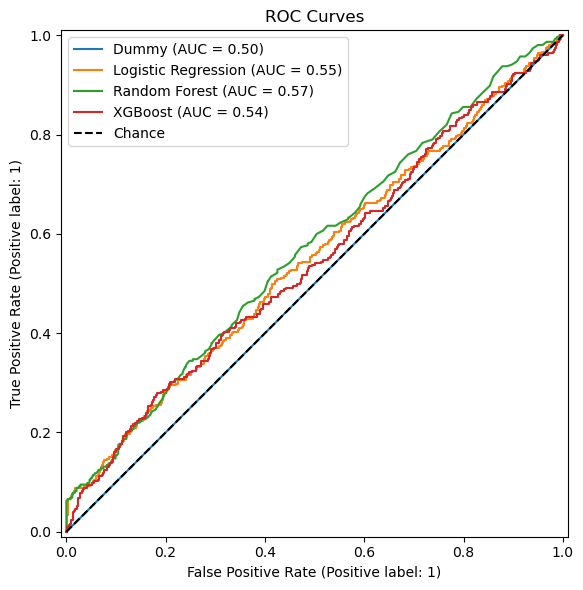

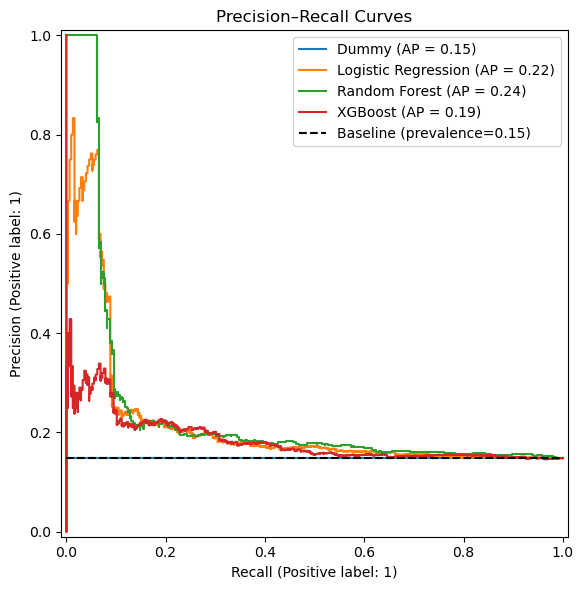

In [69]:
model_preds = {
    "Dummy": (y_test, y_proba_dummy),
    "Logistic Regression": (y_test, y_proba_lr),
    "Random Forest": (y_test, y_proba_rf),
    "XGBoost": (y_test, y_proba_xgb)
}

plt.figure(figsize=(7,6))
for name, (yt, yp) in model_preds.items():
    RocCurveDisplay.from_predictions(yt, yp, name=name, ax=plt.gca())
plt.plot([0,1],[0,1],"k--",label="Chance")
plt.title("ROC Curves"); plt.legend(); plt.tight_layout(); plt.savefig("roc_curves.png", dpi=200); plt.show()

plt.figure(figsize=(7,6))
for name, (yt, yp) in model_preds.items():
    PrecisionRecallDisplay.from_predictions(yt, yp, name=name, ax=plt.gca())
baseline = y_test.mean()
plt.hlines(baseline, 0, 1, colors="k", linestyles="--", label=f"Baseline (prevalence={baseline:.2f})")
plt.title("Precision–Recall Curves"); plt.legend(); plt.tight_layout(); plt.savefig("pr_curves.png", dpi=200); plt.show()

### Threshold analysis 

At low thresholds, the models achieve high recall by flagging many churners, but this comes with very low precision—generating many false alarms. At high thresholds, precision becomes perfect, but recall collapses, meaning almost no churners are identified.

This trade-off illustrates a key business challenge: Netflix must set thresholds based on its retention budget and tolerance for false positives. However, with the current features, threshold tuning alone cannot deliver actionable results. Stronger, time-sensitive behavioral features are needed before threshold selection can meaningfully improve churn targeting.

In [70]:
def threshold_report(name, y_true, y_proba, min_precision=0.25):
    prec, rec, thr = precision_recall_curve(y_true, y_proba)

    # best F1
    f1_vals = np.where((prec + rec) > 0, 2 * prec * rec / (prec + rec), 0)
    idx_f1 = f1_vals.argmax()
    t_f1 = thr[idx_f1 - 1] if idx_f1 > 0 else 0.5

    # Optimize recall while keeping precision above a minimum threshold
    mask = prec >= min_precision
    t_prec = thr[np.where(mask)[0][-1] - 1] if mask.any() and np.where(mask)[0][-1] > 0 else None

    def metrics_at(t):
        y_pred = (y_proba >= t).astype(int)
        return dict(
            threshold=t,
            precision=precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)[0],
            recall=precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)[1],
            f1=precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)[2],
            roc_auc=roc_auc_score(y_true, y_proba),
            pr_auc=average_precision_score(y_true, y_proba),
            cm=confusion_matrix(y_true, y_pred)
        )

    print(f"\n=== {name}: Threshold selection ===")
    m_f1 = metrics_at(t_f1)
    print(f"[Best F1]  t={m_f1['threshold']:.3f} | Precision={m_f1['precision']:.3f}  Recall={m_f1['recall']:.3f}  F1={m_f1['f1']:.3f}  "
          f"(ROC AUC={m_f1['roc_auc']:.3f}, PR AUC={m_f1['pr_auc']:.3f})")
    print("Confusion matrix (tn fp; fn tp):\n", m_f1["cm"])

    if t_prec is not None:
        m_prec = metrics_at(t_prec)
        print(f"\n[Recall@P≥{min_precision:.2f}] t={t_prec:.3f} | Precision={m_prec['precision']:.3f}  Recall={m_prec['recall']:.3f}  F1={m_prec['f1']:.3f}")
        print("Confusion matrix (tn fp; fn tp):\n", m_prec["cm"])
    else:
        print(f"\n[Recall@P≥{min_precision:.2f}] Not achievable (max precision={prec.max():.3f}).")

threshold_report("XGBoost", y_test, y_proba_xgb, min_precision=0.25)
threshold_report("Random Forest", y_test, y_proba_rf, min_precision=0.25)
threshold_report("Logistic Regression", y_test, y_proba_lr, min_precision=0.25)


=== XGBoost: Threshold selection ===
[Best F1]  t=0.260 | Precision=0.156  Recall=0.807  F1=0.261  (ROC AUC=0.542, PR AUC=0.185)
Confusion matrix (tn fp; fn tp):
 [[ 423 1332]
 [  59  246]]

[Recall@P≥0.25] t=0.940 | Precision=0.000  Recall=0.000  F1=0.000
Confusion matrix (tn fp; fn tp):
 [[1754    1]
 [ 305    0]]

=== Random Forest: Threshold selection ===
[Best F1]  t=0.026 | Precision=0.156  Recall=0.938  F1=0.268  (ROC AUC=0.568, PR AUC=0.241)
Confusion matrix (tn fp; fn tp):
 [[ 213 1542]
 [  19  286]]

[Recall@P≥0.25] t=0.697 | Precision=1.000  Recall=0.003  F1=0.007
Confusion matrix (tn fp; fn tp):
 [[1755    0]
 [ 304    1]]

=== Logistic Regression: Threshold selection ===
[Best F1]  t=0.091 | Precision=0.151  Recall=0.925  F1=0.259  (ROC AUC=0.548, PR AUC=0.218)
Confusion matrix (tn fp; fn tp):
 [[ 167 1588]
 [  23  282]]

[Recall@P≥0.25] t=0.902 | Precision=0.000  Recall=0.000  F1=0.000
Confusion matrix (tn fp; fn tp):
 [[1754    1]
 [ 305    0]]


/var/folders/kf/g4m_whs978xfmhgk8j1v8csh0000gn/T/ipykernel_73316/4022013665.py:5: RuntimeWarning: invalid value encountered in divide
  f1_vals = np.where((prec + rec) > 0, 2 * prec * rec / (prec + rec), 0)
/var/folders/kf/g4m_whs978xfmhgk8j1v8csh0000gn/T/ipykernel_73316/4022013665.py:5: RuntimeWarning: invalid value encountered in divide
  f1_vals = np.where((prec + rec) > 0, 2 * prec * rec / (prec + rec), 0)


### Results and interpretation

The initial goal of this project was **Netflix customer churn: identifying the behavioral drivers of user retention**. Using behavioral features (watch time, search activity, recommendations, reviews) with recency-based fields, we trained and evaluated several models.

- **Dummy baseline**: PR AUC = 0.148, equal to churn rate.
- **Logistic Regression**: ROC AUC = 0.55, PR AUC = 0.22. Precision = 0.24, Recall = 0.13, F1 = 0.17. It recovers some churners but at the cost of many false positives.
- **Random Forest**: ROC AUC = 0.57, PR AUC = 0.24. Precision = 1.00 but Recall = 0.06, showing the model predicts very few churners.
- **XGBoost**: ROC AUC = 0.54, PR AUC = 0.19. It achieves a more balanced trade-off (Precision = 0.20, Recall = 0.30, F1 = 0.24), but improvements over baseline remain modest.

From a business perspective, these models offer limited predictive power beyond random chance. Broad retention strategies (e.g., platform-wide promotions, engagement nudges) remain as effective as targeted interventions if targeting relies only on the current aggregate and recency features.

### Conclusion and next steps

To achieve actionable targeting, Netflix needs stronger and more time-sensitive behavioral features. Future work will focus on session-level temporal features (decline, inactivity, volatility) to provide stronger signals for churn detection.